# Results with 100 Iterations

In [1]:
from functools import reduce
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('../src')
import raybay

In [2]:
folders = [
    'SBRT_lung_minsun',
    'ZZ_MK_LLungSBRT3778',
    'ZZ_MK_LULSBRT4544',
    'ZZ_MK_RLSBRT1931',
    'ZZ_MK_RLungSBRT4076',
    'ZZ_MK_RULungSBRT3796',
    'ZZ_MK_SBRTLL7289',
    'ZZ_MK_SBRTLLL8973',
    'ZZ_MK_SBRTRL7289',
    'ZZ_MK_SBRTRUL_2928allviolate'
]

In [3]:
plan_types = ['clinical', 'default', 'random', 'bayes']

## Timing

In [4]:
def get_time_df(plan_type):
    df = pd.DataFrame({
        'patient': folders,
        'plan_type': 10*[plan_type],
        'plan_time': [get_plan_time(folder, plan_type) for folder in folders]
    })
    return df

def get_plan_time(folder, plan_type):
    if plan_type in ('clinical', 'default'):
        raise Exception(f"Time not recorded for {plan_type} plans.")
    plan = np.load(folder + get_plan_name(plan_type), allow_pickle=True)
    return plan.time/3600.0

def get_plan_name(plan_type):
    if plan_type == 'clinical':
        return '/approved/res_approved.pkl'
    if plan_type == 'default':
        return '/default/res_default.pkl'
    if plan_type == 'random':
        return '/bayes/res_linquad_dummy_minimize.pkl'
    if plan_type == 'bayes':
        return '/bayes/res_linquad_gp_minimize.pkl'
    raise Exception(f"Invalid plan_type '{plan_type}'.")

time_df = pd.concat([get_time_df(plan_type) for plan_type in ['random', 'bayes']])
time_df.groupby('plan_type').describe()

plan_time                                                    \
              count      mean       std       min       25%       50%   
plan_type                                                               
bayes          10.0  2.377229  0.537746  1.806067  2.063525  2.268685   
random         10.0  2.011782  0.541586  1.307687  1.563225  1.930469   

                               
                75%       max  
plan_type                      
bayes      2.528324  3.644062  
random     2.413470  2.880300

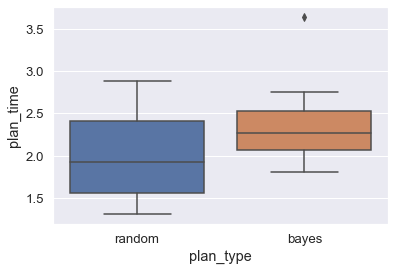

In [5]:
sns.boxplot(x='plan_type', y='plan_time', data=time_df);

## Utility Values

In [6]:
def get_util_df(plan_type):
    df = pd.DataFrame({
        'patient': folders,
        'plan_type': 10*[plan_type],
        'plan_util': [get_plan_util(folder, plan_type) for folder in folders]
    })
    return df

def get_plan_util(folder, plan_type):
    plan = np.load(folder + get_plan_name(plan_type), allow_pickle=True)
    if plan_type in ('clinical', 'default'):
        ref_plan = np.load(folder + get_plan_name('random'), allow_pickle=True)
        return raybay.get_utility(ref_plan.goal_df, plan.goal_dict)[0]
    return -plan.opt_result.fun
    
util_df = pd.concat([get_util_df(plan_type) for plan_type in plan_types])
util_df.groupby('plan_type').describe()

plan_util                                                    \
              count        mean          std          min         25%   
plan_type                                                               
bayes          10.0  412.684219   106.685630   185.052909  355.168655   
clinical       10.0 -769.232355  2803.424147 -8630.470766 -398.060321   
default        10.0 -419.295109   506.428862 -1222.213527 -706.553129   
random         10.0  396.072994   115.239690   159.011493  334.429651   

                                               
                  50%         75%         max  
plan_type                                      
bayes      424.947532  490.793878  537.678328  
clinical   273.066535  383.139593  466.324841  
default   -318.226430   -0.697789  155.170588  
random     425.428612  473.447650  533.831554

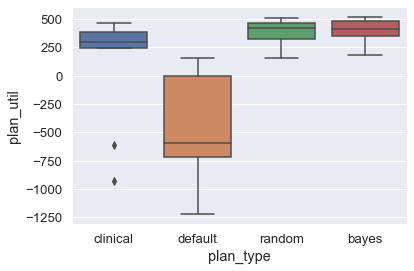

In [7]:
# Don't include clinical plan 8 in plot
sns.boxplot(x='plan_type', y='plan_util', data=util_df.drop(index=8));

## Parameter Values

In [8]:
par_names = [
    '1_Chestwall_MaxDvh',
    '2_D2cm_MaxDose',
    '3_Esophagus_MaxDvh',
    '4_Lungs_MaxDvh',
    '5_Lungs_MaxDvh',
    '7_PTV_MaxDose',
    '8_Rib_MaxDvh',
    '9_Rib_MaxDose',
    '10_SpinalCord_MaxDvh',
    '11_SpinalCord_MaxDose'
]

def get_pars_df(plan_type):
    return pd.concat([get_plan_pars(folder, plan_type) for folder in folders])

def get_plan_pars(folder, plan_type):
    if plan_type in ('clinical', 'default'):
        raise Exception(f"Optimal parameters not saved for {plan_type} plans.")
    plan = np.load(folder + get_plan_name(plan_type), allow_pickle=True)
    df = pd.DataFrame({
        'patient': folder,
        'plan_type': plan_type,
        'par_name': par_names,
        'par_val': plan.opt_result.x,
    })
    return df

pars_df = pd.concat([get_pars_df(plan_type) for plan_type in ['random', 'bayes']])
pars_df.groupby(['par_name', 'plan_type'])['par_val'].describe()

count         mean         std          min  \
par_name              plan_type                                                
10_SpinalCord_MaxDvh  bayes       10.0   499.328208  309.050645   340.000000   
                      random      10.0   625.560770  256.277763   378.176499   
11_SpinalCord_MaxDose bayes       10.0  1250.372824  773.216535   650.000000   
                      random      10.0  1680.177670  608.761934   770.588141   
1_Chestwall_MaxDvh    bayes       10.0  2020.520752  719.722869  1262.298221   
                      random      10.0  2477.726410  519.799982  1412.308819   
2_D2cm_MaxDose        bayes       10.0  1498.477020  363.322726   952.369579   
                      random      10.0  1515.130143  405.799203   634.773748   
3_Esophagus_MaxDvh    bayes       10.0  1022.888250  635.869546   470.000000   
                      random      10.0  1017.519002  389.803216   516.106307   
4_Lungs_MaxDvh        bayes       10.0   742.496904  377.294066   290.000000   
                      random      10.0   743.871810  267.735372   354.353024   
5_Lungs_MaxDvh        bayes       10.0   611.187346  254.967867   310.000000   
                      random      10.0   842.536139  246.516364   451.487557   
7_PTV_MaxDose         bayes       10.0  6525.875442  886.766695  5600.000000   
                      random      10.0  6679.553925  672.320191  5987.884459   
8_Rib_MaxDvh          bayes       10.0  2673.774861  522.086755  1956.915900   
                      random      10.0  2784.646473  398.646192  2030.388077   
9_Rib_MaxDose         bayes       10.0  2468.390186  648.338585  1172.466576   
                      random      10.0  2855.993164  707.286087  1714.632749   

                                         25%          50%          75%  \
par_name              plan_type                                          
10_SpinalCord_MaxDvh  bayes       340.000000   340.000000   474.730399   
                      random      387.685410   621.095569   734.878138   
11_SpinalCord_MaxDose bayes       655.426591   900.731175  1844.039238   
                      random     1278.753220  1797.809231  2234.129091   
1_Chestwall_MaxDvh    bayes      1459.580816  1693.245221  2785.600282   
                      random     2404.545811  2620.741823  2882.632130   
2_D2cm_MaxDose        bayes      1201.653989  1535.492549  1758.992514   
                      random     1317.498529  1607.358585  1791.683507   
3_Esophagus_MaxDvh    bayes       471.425903   731.976602  1719.806421   
                      random      637.698809  1081.790209  1383.001609   
4_Lungs_MaxDvh        bayes       388.170255   727.138284  1137.183720   
                      random      527.235790   798.045019   951.933582   
5_Lungs_MaxDvh        bayes       387.224354   646.931342   747.716328   
                      random      703.737407   843.374506   926.890924   
7_PTV_MaxDose         bayes      5600.000000  6650.654931  7180.460047   
                      random     6040.451578  6466.441918  7426.813833   
8_Rib_MaxDvh          bayes      2208.740929  2749.351843  3200.000000   
                      random     2485.639271  2892.737045  3100.879766   
9_Rib_MaxDose         bayes      2105.971537  2482.248220  2998.093336   
                      random     2528.340033  2819.294287  2973.467236   

                                         max  
par_name              plan_type               
10_SpinalCord_MaxDvh  bayes      1267.869230  
                      random     1165.258786  
11_SpinalCord_MaxDose bayes      2600.000000  
                      random     2290.749615  
1_Chestwall_MaxDvh    bayes      3000.000000  
                      random     2959.820315  
2_D2cm_MaxDose        bayes      2070.358038  
                      random     1935.331710  
3_Esophagus_MaxDvh    bayes      1880.000000  
                      random     1428.826988  
4_Lungs_MaxDvh        bayes      1160.000000  
                      random    

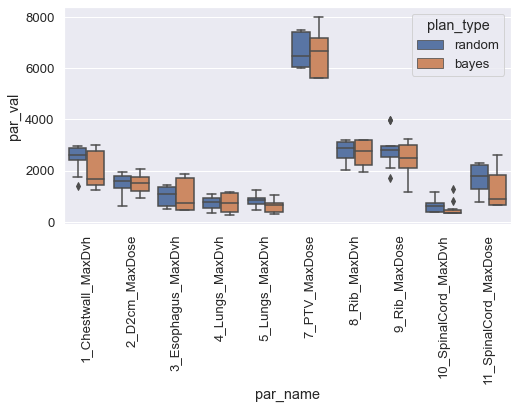

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x='par_name', y='par_val', hue='plan_type', data=pars_df, ax=ax)
ax.set_xticks(np.arange(len(par_names)))
ax.set_xticklabels(labels=par_names, rotation=90);

In [10]:
# Do we need to do anything special for PTV MaxDose?
# Lowest the values could be is 1/4
# What is the lowest that PTV MaxDose could be? Rescale?
# Which is more interpretable?
def get_par_diff(row):
    goal_val = get_goal_val(row)
    return 100*(row['par_val'] - goal_val)/goal_val

def get_goal_val(row):
    plan = np.load(row['patient'] + get_plan_name(row['plan_type']), allow_pickle=True)
    ii = get_par_idx(row)
    return plan.goal_df.iloc[ii]['AcceptanceLevel']

def get_par_idx(row):
    for ii, par_name in enumerate(par_names):
        if row['par_name'] == par_name:
            if ii < 5:
                return ii
            if ii >= 5:
                return ii + 1
            
pars_df['par_diff'] = pars_df.apply(get_par_diff, axis=1)
pars_df.groupby(['par_name', 'plan_type'])['par_diff'].describe()

count       mean        std        min  \
par_name              plan_type                                           
10_SpinalCord_MaxDvh  bayes       10.0 -63.284691  22.724312 -75.000000   
                      random      10.0 -54.002885  18.843953 -72.192904   
11_SpinalCord_MaxDose bayes       10.0 -51.908738  29.739098 -75.000000   
                      random      10.0 -35.377782  23.413921 -70.361995   
1_Chestwall_MaxDvh    bayes       10.0 -32.649308  23.990762 -57.923393   
                      random      10.0 -17.409120  17.326666 -52.923039   
2_D2cm_MaxDose        bayes       10.0 -42.545409  11.014988 -60.317934   
                      random      10.0 -41.823922  13.844517 -73.551094   
3_Esophagus_MaxDvh    bayes       10.0 -45.591051  33.822848 -75.000000   
                      random      10.0 -45.876649  20.734214 -72.547537   
4_Lungs_MaxDvh        bayes       10.0 -35.991646  32.525351 -75.000000   
                      random      10.0 -35.873120  23.080636 -69.452325   
5_Lungs_MaxDvh        bayes       10.0 -50.710698  20.561925 -75.000000   
                      random      10.0 -32.053537  19.880352 -63.589713   
7_PTV_MaxDose         bayes       10.0 -18.426557  11.084584 -30.000000   
                      random      10.0 -16.505576   8.404002 -25.151444   
8_Rib_MaxDvh          bayes       10.0 -16.444536  16.315211 -38.846378   
                      random      10.0 -12.979798  12.457694 -36.550373   
9_Rib_MaxDose         bayes       10.0 -38.290245  16.208465 -70.688336   
                      random      10.0 -28.600171  17.682152 -57.134181   

                                       25%        50%        75%        max  
par_name              plan_type                                              
10_SpinalCord_MaxDvh  bayes     -75.000000 -75.000000 -65.093353  -6.774321  
                      random    -71.493720 -54.331208 -45.964843 -14.319207  
11_SpinalCord_MaxDose bayes     -74.791285 -65.356493 -29.075414   0.000000  
                      random    -50.817184 -30.853491 -14.071958 -11.894246  
1_Chestwall_MaxDvh    bayes     -51.347306 -43.558493  -7.146657   0.000000  
                      random    -19.848473 -12.641939  -3.912262  -1.339323  
2_D2cm_MaxDose        bayes     -52.202151 -38.583795 -35.924286 -29.291051  
                      random    -48.009456 -35.488943 -32.062626 -29.737902  
3_Esophagus_MaxDvh    bayes     -74.924154 -61.065074  -8.520935   0.000000  
                      random    -66.079851 -42.457968 -26.436085 -23.998564  
4_Lungs_MaxDvh        bayes     -66.537047 -37.315665  -1.966921   0.000000  
                      random    -54.548639 -31.203016 -17.936760  -6.187628  
5_Lungs_MaxDvh        bayes     -68.772230 -47.828118 -39.700296 -16.220654  
                      random    -43.246983 -31.985927 -25.250732  -0.641208  
7_PTV_MaxDose         bayes     -30.000000 -16.866813 -10.244249   0.000000  
                      random    -24.494355 -19.169476  -7.164827  -6.614994  
8_Rib_MaxDvh          bayes     -30.976846 -14.082755   0.000000   0.000000  
                      random    -22.323773  -9.601967  -3.097507  -0.422641  
9_Rib_MaxDose         bayes     -47.350712 -37.943795 -25.047667 -18.757440  
                      random    -36.791499 -29.517643 -25.663319  -0.979289

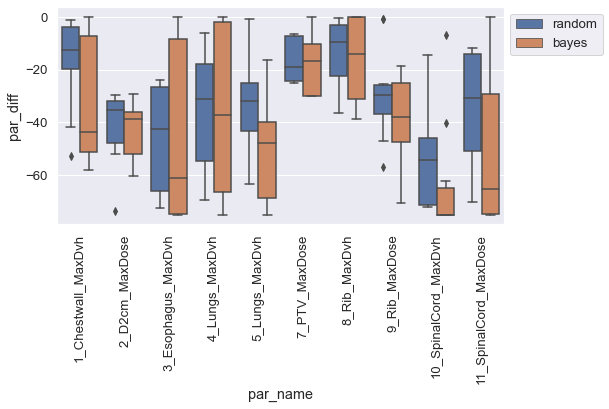

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x='par_name', y='par_diff', hue='plan_type', data=pars_df, ax=ax)
ax.set_xticks(np.arange(len(par_names)))
ax.set_xticklabels(labels=par_names, rotation=90)
ax.legend(bbox_to_anchor=(1, 1));

## Dose Values

### Compared to Clinical Goal Values

### Compared to Clinical Plan Values